In [7]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## 1. Load Data from qb_contract_value View

**Note:** This analysis uses the `qb_contract_value` view which pre-aggregates QB performance metrics with contract data. The view automatically handles:
- Player name standardization and matching  
- Custom QB rating calculations
- Salary percentile rankings by season
- Value score computations
- Contract year expansions

In [23]:
# Load from CSV (contains corrected ratings matching the app)
qb_contracts = pd.read_csv('../../modeling/models/qb_contract_value.csv')

print(f"Loaded {len(qb_contracts)} QB-season records with contract data")
print(f"\nColumns available:")
print(qb_contracts.columns.tolist())
print(f"\nYears covered: {qb_contracts['season'].min()} - {qb_contracts['season'].max()}")
print(f"Unique QBs: {qb_contracts['player_name'].nunique()}")
print(f"\nSample data (sorted by rating descending):")
qb_contracts.sort_values('custom_rating', ascending=False).head()

Loaded 630 QB-season records with contract data

Columns available:
['player_name', 'player_id', 'season', 'team', 'attempts', 'custom_rating', 'salary', 'salary_millions', 'salary_percentile', 'value_score', 'value_category', 'rating_per_million', 'total_pass_epa', 'cpoe', 'success_rate_pct', 'completion_pct', 'td_rate_pct', 'turnover_rate_pct', 'total_wpa', 'total_value', 'guaranteed', 'year_signed', 'contract_length']

Years covered: 2010 - 2025
Unique QBs: 124

Sample data (sorted by rating descending):


,player_name,player_id,season,team,attempts,custom_rating,salary,salary_millions,salary_percentile,value_score,value_category,rating_per_million,total_pass_epa,cpoe,success_rate_pct,completion_pct,td_rate_pct,turnover_rate_pct,total_wpa,total_value,guaranteed,year_signed,contract_length
0,P.Mahomes,00-0033873,2022,Chiefs,834.0,91.352657,45.000,45.0,91.2,0.2,Fair Value,2.03,245.0,4.1,54.1,60.8,5.6,1.4,7.30,450.00,63.081905,2020,10
1,P.Manning,00-0010346,2013,Colts,807.0,91.006166,18.000,18.0,84.1,6.9,Fair Value,5.06,264.0,6.5,55.3,67.0,7.1,1.5,4.80,90.00,20.000000,2011,5
2,P.Manning,00-0010346,2013,Broncos,807.0,91.006166,19.200,19.2,90.9,0.1,Fair Value,4.74,264.0,6.5,55.3,67.0,7.1,1.5,4.80,96.00,18.000000,2012,5
3,A.Rodgers,00-0023459,2020,Packers,659.0,90.471405,33.500,33.5,86.8,3.6,Fair Value,2.70,213.7,6.8,54.5,64.9,7.8,0.9,4.44,134.00,78.700000,2018,4
4,A.Rodgers,00-0023459,2011,Packers,633.0,90.335196,12.704,12.7,77.8,12.6,Good Value,7.11,238.4,7.4,53.1,58.1,7.2,1.1,4.76,63.52,20.000000,2008,5


## 3. Best & Worst Value QBs (All-Time)

In [9]:
# Display basic info
print("Dataset Overview:")
print(f"  Total QB-seasons: {len(qb_contracts):,}")
print(f"  Seasons: {qb_contracts['season'].min()}-{qb_contracts['season'].max()}")
print(f"  Unique QBs: {qb_contracts['player_name'].nunique()}")

print("\nValue Category Distribution:")
print(qb_contracts['value_category'].value_counts())

print("\nSalary Statistics (in millions):")
print(qb_contracts['salary_millions'].describe())

print("\nCustom Rating Statistics:")
print(qb_contracts['custom_rating'].describe())

print("\nValue Score Statistics:")
print(qb_contracts['value_score'].describe())

Dataset Overview:
  Total QB-seasons: 626
  Seasons: 2010-2025
  Unique QBs: 124

Value Category Distribution:
value_category
Excellent Value      338
Fair Value           137
Good Value            77
Overpaid              49
Severely Overpaid     25
Name: count, dtype: int64

Salary Statistics (in millions):
count    626.000000
mean      14.654233
std       14.034810
min        0.170000
25%        3.500000
50%        9.500000
75%       20.810000
max       60.000000
Name: salary_millions, dtype: float64

Custom Rating Statistics:
count    626.000000
mean      74.146326
std       11.105266
min       50.000000
25%       66.200000
50%       73.450000
75%       81.800000
max      100.000000
Name: custom_rating, dtype: float64

Value Score Statistics:
count    626.000000
mean      24.351597
std       27.685835
min      -38.900000
25%        2.050000
50%       23.150000
75%       45.775000
max       94.900000
Name: value_score, dtype: float64


In [24]:
# Top 20 best value QBs (all-time)
best_value = qb_contracts.nlargest(20, 'value_score')[[
    'player_name', 'season', 'custom_rating', 'salary_millions', 'salary_percentile', 'value_score', 'value_category'
]].copy()

best_value.columns = ['Player', 'Season', 'Rating', 'Salary ($M)', 'Salary %ile', 'Value Score', 'Category']

print("="*100)
print("TOP 20 BEST VALUE QUARTERBACKS (All Years)")
print("="*100)
print(best_value.to_string(index=False))

TOP 20 BEST VALUE QUARTERBACKS (All Years)
      Player  Season    Rating  Salary ($M)  Salary %ile  Value Score        Category
  D.Prescott    2016 83.808018         0.68          2.8         81.0 Excellent Value
   K.Cousins    2015 80.509703         0.64          0.0         80.5 Excellent Value
    R.Wilson    2012 81.845596         0.75          2.8         79.1 Excellent Value
    R.Wilson    2015 83.433423         0.75          4.4         79.0 Excellent Value
     B.Purdy    2022 78.204691         0.93          0.0         78.2 Excellent Value
     B.Purdy    2024 80.101484         0.93          2.2         77.9 Excellent Value
     J.Hurts    2022 82.279429         1.51          5.9         76.4 Excellent Value
     N.Foles    2013 80.697517         0.69          4.5         76.2 Excellent Value
     M.Jones    2025 78.254589         3.50          2.9         75.3 Excellent Value
G.Minshew II    2020 74.242458         0.68          0.0         74.2 Excellent Value
   N.Mullen

In [11]:
# Worst value QBs (most overpaid)
worst_value = qb_contracts.nsmallest(20, 'value_score')[[
    'player_name', 'season', 'custom_rating', 'salary_millions', 'salary_percentile', 'value_score', 'value_category'
]].copy()

worst_value.columns = ['Player', 'Season', 'Rating', 'Salary ($M)', 'Salary %ile', 'Value Score', 'Category']

print("\n" + "="*100)
print("TOP 20 MOST OVERPAID QUARTERBACKS (All Years)")
print("="*100)
print(worst_value.to_string(index=False))


TOP 20 MOST OVERPAID QUARTERBACKS (All Years)
    Player  Season  Rating  Salary ($M)  Salary %ile  Value Score          Category
  R.Wilson    2022    58.2        49.00         97.1        -38.9 Severely Overpaid
  J.Flacco    2013    58.9        20.10         95.5        -36.6 Severely Overpaid
D.Prescott    2024    65.9        60.00        100.0        -34.1 Severely Overpaid
 A.Rodgers    2022    68.6        50.27        100.0        -31.4 Severely Overpaid
   C.Wentz    2020    53.4        32.00         81.6        -28.2 Severely Overpaid
  K.Murray    2022    66.1        46.10         94.1        -28.0 Severely Overpaid
    M.Ryan    2013    70.4        20.75         97.7        -27.3 Severely Overpaid
  J.Flacco    2017    65.7        22.13         92.5        -26.8 Severely Overpaid
S.Bradford    2011    55.4        13.00         81.5        -26.1 Severely Overpaid
    D.Carr    2017    72.6        25.00         97.5        -24.9 Severely Overpaid
  J.Flacco    2016    69.6   

## 4. Year-by-Year Analysis

In [25]:
# Best value by year
print("\n" + "="*100)
print("BEST VALUE QB BY SEASON")
print("="*100)

for year in sorted(qb_contracts['season'].unique()):
    year_data = qb_contracts[qb_contracts['season'] == year].nlargest(1, 'value_score')
    if len(year_data) > 0:
        row = year_data.iloc[0]
        print(f"{year}: {row['player_name']:20s} - Rating: {row['custom_rating']:.1f}, Salary: ${row['salary_millions']:.2f}M, Value: {row['value_score']:+.1f}")


BEST VALUE QB BY SEASON
2010: C.McCoy              - Rating: 71.5, Salary: $0.64M, Value: +71.5
2011: C.McCoy              - Rating: 69.9, Salary: $0.64M, Value: +69.9
2012: R.Wilson             - Rating: 81.8, Salary: $0.75M, Value: +79.1
2013: N.Foles              - Rating: 80.7, Salary: $0.69M, Value: +76.2
2014: R.Wilson             - Rating: 78.6, Salary: $0.75M, Value: +71.6
2015: K.Cousins            - Rating: 80.5, Salary: $0.64M, Value: +80.5
2016: D.Prescott           - Rating: 83.8, Salary: $0.68M, Value: +81.0
2017: T.Siemian            - Rating: 66.8, Salary: $0.58M, Value: +66.8
2018: N.Mullens            - Rating: 74.1, Salary: $0.17M, Value: +74.1
2019: K.Allen              - Rating: 70.3, Salary: $0.49M, Value: +70.3
2020: G.Minshew II         - Rating: 74.2, Salary: $0.68M, Value: +74.2
2021: T.Huntley            - Rating: 69.2, Salary: $0.76M, Value: +69.2
2022: B.Purdy              - Rating: 78.2, Salary: $0.93M, Value: +78.2
2023: B.Purdy              - Rating: 85

In [13]:
# Most overpaid by year
print("\n" + "="*100)
print("MOST OVERPAID QB BY SEASON")
print("="*100)

for year in sorted(qb_contracts['season'].unique()):
    year_data = qb_contracts[qb_contracts['season'] == year].nsmallest(1, 'value_score')
    if len(year_data) > 0:
        row = year_data.iloc[0]
        print(f"{year}: {row['player_name']:20s} - Rating: {row['custom_rating']:.1f}, Salary: ${row['salary_millions']:.2f}M, Value: {row['value_score']:+.1f}")


MOST OVERPAID QB BY SEASON
2010: D.McNabb             - Rating: 67.8, Salary: $14.85M, Value: -22.2
2011: S.Bradford           - Rating: 55.4, Salary: $13.00M, Value: -26.1
2012: M.Sanchez            - Rating: 54.9, Salary: $13.49M, Value: -20.1
2013: J.Flacco             - Rating: 58.9, Salary: $20.10M, Value: -36.6
2014: C.Kaepernick         - Rating: 69.2, Salary: $19.00M, Value: -19.2
2015: A.Rodgers            - Rating: 75.2, Salary: $22.00M, Value: -24.8
2016: J.Flacco             - Rating: 69.6, Salary: $22.13M, Value: -24.8
2017: J.Flacco             - Rating: 65.7, Salary: $22.13M, Value: -26.8
2018: M.Stafford           - Rating: 69.4, Salary: $27.00M, Value: -22.5
2019: C.Wentz              - Rating: 68.6, Salary: $32.00M, Value: -22.6
2020: C.Wentz              - Rating: 53.4, Salary: $32.00M, Value: -28.2
2021: R.Wilson             - Rating: 73.7, Salary: $35.00M, Value: -18.4
2022: R.Wilson             - Rating: 58.2, Salary: $49.00M, Value: -38.9
2023: J.Burrow         

## 5. Visualizations

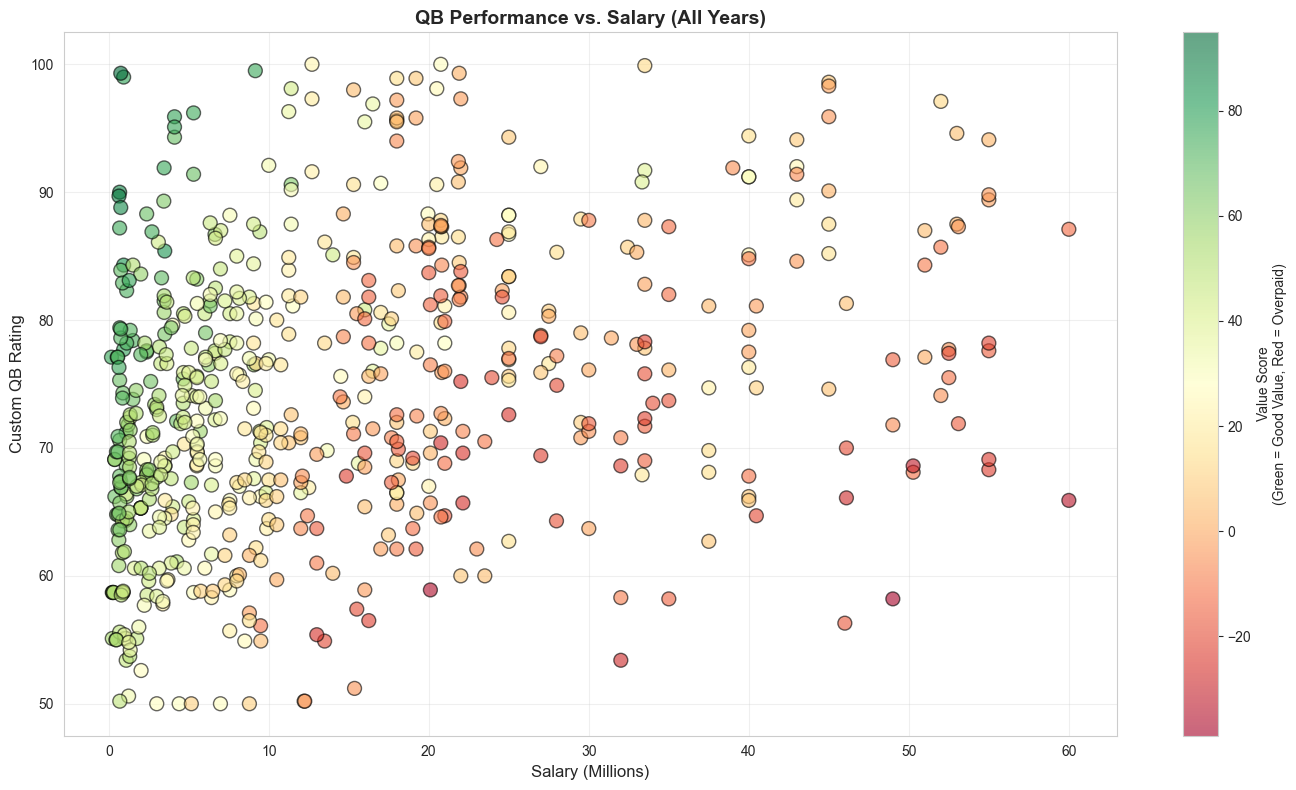

In [14]:
# Scatter plot: Rating vs. Salary
fig, ax = plt.subplots(figsize=(14, 8))

scatter = ax.scatter(
    qb_contracts['salary_millions'],
    qb_contracts['custom_rating'],
    c=qb_contracts['value_score'],
    cmap='RdYlGn',
    s=100,
    alpha=0.6,
    edgecolors='black'
)

ax.set_xlabel('Salary (Millions)', fontsize=12)
ax.set_ylabel('Custom QB Rating', fontsize=12)
ax.set_title('QB Performance vs. Salary (All Years)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

cbar = plt.colorbar(scatter, label='Value Score')
cbar.set_label('Value Score\n(Green = Good Value, Red = Overpaid)', fontsize=10)

plt.tight_layout()
plt.show()

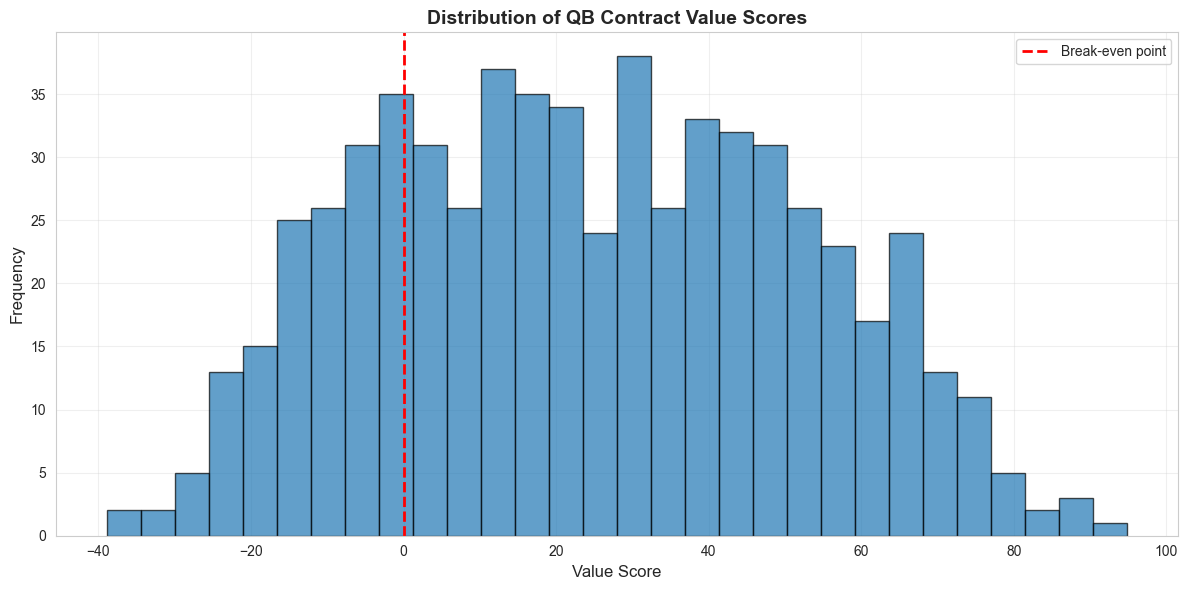

In [15]:
# Distribution of value scores
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(qb_contracts['value_score'], bins=30, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Break-even point')
ax.set_xlabel('Value Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of QB Contract Value Scores', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

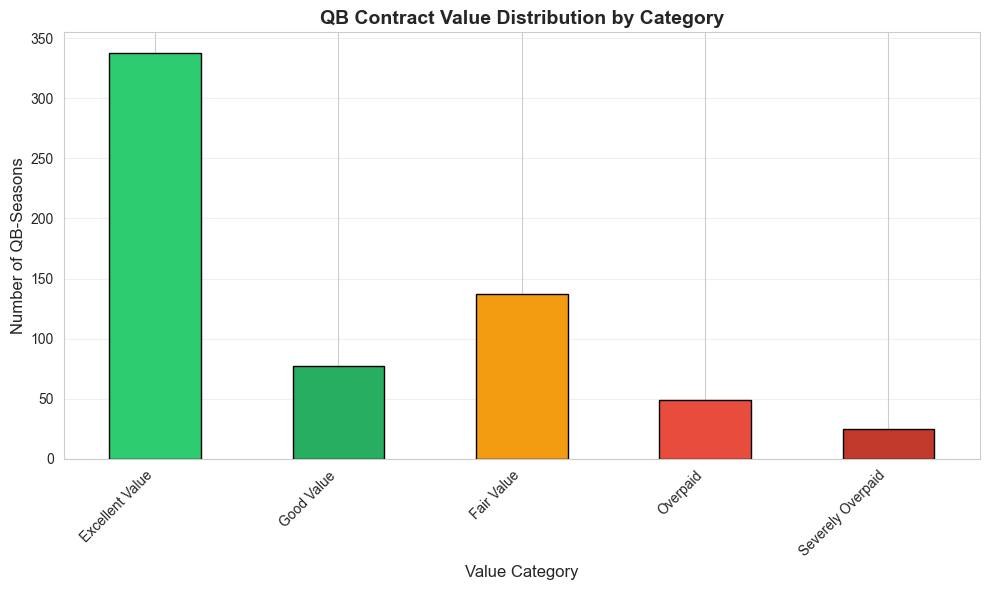

In [16]:
# Value category distribution
fig, ax = plt.subplots(figsize=(10, 6))

category_counts = qb_contracts['value_category'].value_counts()
category_order = ['Excellent Value', 'Good Value', 'Fair Value', 'Overpaid', 'Severely Overpaid']
category_counts = category_counts.reindex(category_order, fill_value=0)

colors = ['#2ecc71', '#27ae60', '#f39c12', '#e74c3c', '#c0392b']
category_counts.plot(kind='bar', ax=ax, color=colors, edgecolor='black')

ax.set_xlabel('Value Category', fontsize=12)
ax.set_ylabel('Number of QB-Seasons', fontsize=12)
ax.set_title('QB Contract Value Distribution by Category', fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Alternative Value Metrics - EPA/WPA Based Approach

In [28]:
# Calculate alternative value metrics for 2025 season
year_2025 = qb_contracts[qb_contracts['season'] == 2025].copy()

# Metric 1: EPA per million dollars
year_2025['epa_per_million'] = year_2025['total_pass_epa'] / (year_2025['salary_millions'] + 1)

# Metric 2: WPA per million dollars
year_2025['wpa_per_million'] = year_2025['total_wpa'] / (year_2025['salary_millions'] + 1)

# Metric 3: Availability factor (attempts relative to full season)
year_2025['availability_factor'] = year_2025['attempts'] / 550

# Combined value metric
year_2025['combined_value'] = (
    0.50 * year_2025['epa_per_million'] +
    0.30 * year_2025['wpa_per_million'] +
    0.20 * year_2025['availability_factor']
)

# Display top 15 by combined value
print("="*100)
print("2025 SEASON - BEST CONTRACT VALUE (EPA/WPA Based Approach)")
print("="*100)

best_2025 = year_2025.nlargest(15, 'combined_value')[[
    'player_name', 'team', 'custom_rating', 'salary_millions', 
    'total_pass_epa', 'total_wpa', 'attempts', 'combined_value'
]].copy()

for idx, row in best_2025.iterrows():
    print(f"{row['player_name']:20s} ({row['team']:6s}) - "
          f"Rating: {row['custom_rating']:5.1f}, Salary: ${row['salary_millions']:6.2f}M, "
          f"EPA: {row['total_pass_epa']:6.1f}, WPA: {row['total_wpa']:5.2f}, "
          f"Value: {row['combined_value']:6.2f}")

print("\n" + "="*100)
print("2025 SEASON - WORST CONTRACT VALUE (EPA/WPA Based Approach)")
print("="*100)

worst_2025 = year_2025.nsmallest(10, 'combined_value')[[
    'player_name', 'team', 'custom_rating', 'salary_millions', 
    'total_pass_epa', 'total_wpa', 'attempts', 'combined_value'
]].copy()

for idx, row in worst_2025.iterrows():
    print(f"{row['player_name']:20s} ({row['team']:6s}) - "
          f"Rating: {row['custom_rating']:5.1f}, Salary: ${row['salary_millions']:6.2f}M, "
          f"EPA: {row['total_pass_epa']:6.1f}, WPA: {row['total_wpa']:5.2f}, "
          f"Value: {row['combined_value']:6.2f}")

2025 SEASON - BEST CONTRACT VALUE (EPA/WPA Based Approach)
D.Maye               (Patriots) - Rating:  84.0, Salary: $  9.16M, EPA:  130.3, WPA:  3.24, Value:   6.68
B.Nix                (Broncos) - Rating:  77.9, Salary: $  4.65M, EPA:   54.5, WPA:  2.72, Value:   5.15
M.Jones              (49ers ) - Rating:  78.3, Salary: $  3.50M, EPA:   40.7, WPA:  1.63, Value:   4.74
D.Jones              (Colts ) - Rating:  79.4, Salary: $ 14.00M, EPA:   65.1, WPA:  1.55, Value:   2.36
C.Williams           (Bears ) - Rating:  75.5, Salary: $  9.87M, EPA:   39.8, WPA:  1.23, Value:   2.04
C.Stroud             (Texans) - Rating:  75.3, Salary: $  9.07M, EPA:   37.0, WPA:  0.43, Value:   1.98
J.Dart               (Giants) - Rating:  74.0, Salary: $  4.24M, EPA:   15.1, WPA:  0.54, Value:   1.57
M.Stafford           (Rams  ) - Rating:  82.1, Salary: $ 40.00M, EPA:   93.4, WPA:  3.04, Value:   1.32
M.Stafford           (Rams  ) - Rating:  82.1, Salary: $ 40.00M, EPA:   93.4, WPA:  3.04, Value:   1.32
P.

## Rank-Based Value Analysis (2025)

In [27]:
# Rank-based value: Compare where QB ranks in rating vs where they rank in salary
year_2025_ranks = qb_contracts[qb_contracts['season'] == 2025].copy()

# Calculate ranks (1 = best/highest)
year_2025_ranks['rating_rank'] = year_2025_ranks['custom_rating'].rank(ascending=False, method='min').astype(int)
year_2025_ranks['salary_rank'] = year_2025_ranks['salary_millions'].rank(ascending=False, method='min').astype(int)

# Rank difference: positive = paid less than performance, negative = paid more than performance
year_2025_ranks['rank_value'] = year_2025_ranks['salary_rank'] - year_2025_ranks['rating_rank']

print("="*120)
print("2025 SEASON - RANK-BASED VALUE ANALYSIS")
print("="*120)
print(f"{'Player':<20} {'Team':<8} {'Rating':<8} {'Salary':<12} {'Rating Rank':<13} {'Salary Rank':<13} {'Rank Diff':<10} {'Value Assessment'}")
print("="*120)

# Sort by rank value (highest = best value)
rank_sorted = year_2025_ranks.sort_values('rank_value', ascending=False)

for idx, row in rank_sorted.iterrows():
    rating_rank = row['rating_rank']
    salary_rank = row['salary_rank']
    rank_diff = row['rank_value']
    
    # Assess value
    if rank_diff >= 10:
        assessment = "Excellent Value"
    elif rank_diff >= 5:
        assessment = "Good Value"
    elif rank_diff >= -5:
        assessment = "Fair Value"
    elif rank_diff >= -10:
        assessment = "Overpaid"
    else:
        assessment = "Severely Overpaid"
    
    print(f"{row['player_name']:<20} {row['team']:<8} {row['custom_rating']:>6.1f}   "
          f"${row['salary_millions']:>8.2f}M   {rating_rank:>5}         {salary_rank:>5}         "
          f"{rank_diff:>+4}       {assessment}")

print("\n" + "="*120)
print("INTERPRETATION:")
print("  Rank Diff > 0:  QB is paid LESS than their performance rank (good value)")
print("  Rank Diff < 0:  QB is paid MORE than their performance rank (overpaid)")
print("  Example: Rating Rank #5, Salary Rank #20 = +15 difference (excellent value)")
print("="*120)

2025 SEASON - RANK-BASED VALUE ANALYSIS
Player               Team     Rating   Salary       Rating Rank   Salary Rank   Rank Diff  Value Assessment
D.Maye               Patriots   84.0   $    9.16M       2            27          +25       Excellent Value
M.Jones              49ers      78.3   $    3.50M      13            34          +21       Excellent Value
B.Nix                Broncos    77.9   $    4.65M      14            31          +17       Excellent Value
J.Dart               Giants     74.0   $    4.24M      20            33          +13       Excellent Value
C.Stroud             Texans     75.3   $    9.07M      18            28          +10       Excellent Value
J.Brissett           Cardinals   74.1   $    6.25M      19            29          +10       Excellent Value
D.Jones              Colts      79.4   $   14.00M      11            21          +10       Excellent Value
S.Darnold            Seahawks   80.5   $   33.50M       8            17           +9       Good Value


## 6. Export for Streamlit App

In [17]:
# Prepare final dataset for Streamlit
app_data = qb_contracts[[
    'player_name', 'season', 'team', 'attempts',
    'custom_rating', 'salary_millions',
    'value_score', 'value_category',
    'total_pass_epa', 'cpoe', 'success_rate_pct',
    'completion_pct', 'td_rate_pct'
]].copy()

# Rename columns for display
app_data.columns = [
    'Player', 'Season', 'Team', 'Attempts',
    'Rating', 'Salary ($M)',
    'Value Score', 'Value Category',
    'EPA', 'CPOE', 'Success Rate %',
    'Completion %', 'TD Rate %'
]

print(f"\nCreated app dataset with {len(app_data)} records")
print("\nSample:")
app_data.head(10)


Created app dataset with 626 records

Sample:


,Player,Season,Team,Attempts,Rating,Salary ($M),Value Score,Value Category,EPA,CPOE,Success Rate %,Completion %,TD Rate %
0,M.Jones,2025,49ers,312.0,85.4,3.50,82.5,Excellent Value,40.7,3.7,52.2,64.4,3.9
1,D.Maye,2025,Patriots,475.0,99.5,9.16,76.0,Excellent Value,130.3,9.6,52.8,58.1,4.5
2,S.Rattler,2025,Saints,287.0,71.2,1.09,71.2,Excellent Value,-28.1,2.4,46.0,60.6,2.6
3,J.Dart,2025,Giants,277.0,72.1,4.24,66.2,Excellent Value,15.1,-0.2,44.0,52.3,3.5
4,B.Nix,2025,Broncos,512.0,75.4,4.65,63.6,Excellent Value,54.5,-1.5,44.1,58.0,3.5
5,J.Brissett,2025,Cardinals,395.0,76.5,6.25,58.9,Excellent Value,6.7,2.9,47.3,58.0,3.7
6,M.Penix,2025,Falcons,303.0,71.3,5.72,56.6,Excellent Value,10.5,-3.6,46.2,54.8,2.9
7,C.Stroud,2025,Texans,353.0,76.5,9.07,55.9,Excellent Value,37.0,0.6,45.6,56.1,3.3
8,J.Flacco,2025,CIN/CLE,429.0,61.1,4.25,52.3,Excellent Value,-44.1,-2.9,41.0,57.6,3.4
9,J.Daniels,2025,Commanders,242.0,71.3,9.44,44.8,Excellent Value,4.7,-2.7,46.3,47.1,3.0


In [18]:
# Save to CSV for easy loading in Streamlit
output_path = '../project_CSVs/qb_contract_value_analysis.csv'
app_data.to_csv(output_path, index=False)
print(f"\nSaved contract value data to: {output_path}")
print(f"Ready for Streamlit app integration!")


Saved contract value data to: ../project_CSVs/qb_contract_value_analysis.csv
Ready for Streamlit app integration!


## 7. Key Insights Summary

In [19]:
category_order = ['Excellent Value', 'Good Value', 'Fair Value', 'Overpaid', 'Severely Overpaid']

print("="*100)
print("KEY INSIGHTS FOR STREAMLIT APP")
print("="*100)

print(f"\n1. DATASET OVERVIEW:")
print(f"   - Total QB-seasons analyzed: {len(app_data)}")
print(f"   - Years covered: {app_data['Season'].min()} - {app_data['Season'].max()}")
print(f"   - Unique QBs: {app_data['Player'].nunique()}")

print(f"\n2. VALUE DISTRIBUTION:")
for category in category_order:
    count = len(app_data[app_data['Value Category'] == category])
    pct = (count / len(app_data)) * 100
    print(f"   - {category:20s}: {count:3d} ({pct:.1f}%)")

print(f"\n3. BEST VALUE (Top 5):")
for i, row in app_data.nlargest(5, 'Value Score').iterrows():
    print(f"   {row['Player']:20s} ({row['Season']}) - Rating: {row['Rating']:.1f}, Salary: ${row['Salary ($M)']:.1f}M, Value: {row['Value Score']:+.1f}")

print(f"\n4. WORST VALUE (Bottom 5):")
for i, row in app_data.nsmallest(5, 'Value Score').iterrows():
    print(f"   {row['Player']:20s} ({row['Season']}) - Rating: {row['Rating']:.1f}, Salary: ${row['Salary ($M)']:.1f}M, Value: {row['Value Score']:+.1f}")

print(f"\n5. RECOMMENDED STREAMLIT FEATURES:")
print(f"   - Year filter (dropdown or slider)")
print(f"   - Conditional formatting: Green for positive value, Red for negative")
print(f"   - Sortable columns")
print(f"   - Two side-by-side tables: Best Value vs Worst Value")
print(f"   - Scatter plot: Rating vs Salary with color-coded value scores")

print("\n" + "="*100)

KEY INSIGHTS FOR STREAMLIT APP

1. DATASET OVERVIEW:
   - Total QB-seasons analyzed: 626
   - Years covered: 2010 - 2025
   - Unique QBs: 124

2. VALUE DISTRIBUTION:
   - Excellent Value     : 338 (54.0%)
   - Good Value          :  77 (12.3%)
   - Fair Value          : 137 (21.9%)
   - Overpaid            :  49 (7.8%)
   - Severely Overpaid   :  25 (4.0%)

3. BEST VALUE (Top 5):
   R.Wilson             (2015) - Rating: 99.3, Salary: $0.8M, Value: +94.9
   K.Cousins            (2015) - Rating: 89.7, Salary: $0.6M, Value: +89.7
   D.Prescott           (2016) - Rating: 90.0, Salary: $0.7M, Value: +87.2
   R.Wilson             (2012) - Rating: 88.8, Salary: $0.8M, Value: +86.0
   M.Jones              (2025) - Rating: 85.4, Salary: $3.5M, Value: +82.5

4. WORST VALUE (Bottom 5):
   R.Wilson             (2022) - Rating: 58.2, Salary: $49.0M, Value: -38.9
   J.Flacco             (2013) - Rating: 58.9, Salary: $20.1M, Value: -36.6
   D.Prescott           (2024) - Rating: 65.9, Salary: $60.0M,

In [20]:
# Close database connection
conn.close()
print("\nDatabase connection closed.")


Database connection closed.
